In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
from xgboost import XGBClassifier

%matplotlib inline 

## Load Data

In [50]:
#dict for dtypes
dtypes = {'age':'int64', 'sex':'category','cp':'category','trestbps':'int64',
          'chol':'int64' ,'restecg':'category','thalach':'int64', 'exang':'category',
          'oldpeak':'float64', 'slope':'category','ca':'category','target':'int64', 'fbs':'category', 'thal':'category' }

df_data_raw = pd.read_csv('/data/heart.csv',dtype=dtypes)

## Data Cleaning and Exploratory Data Analysis

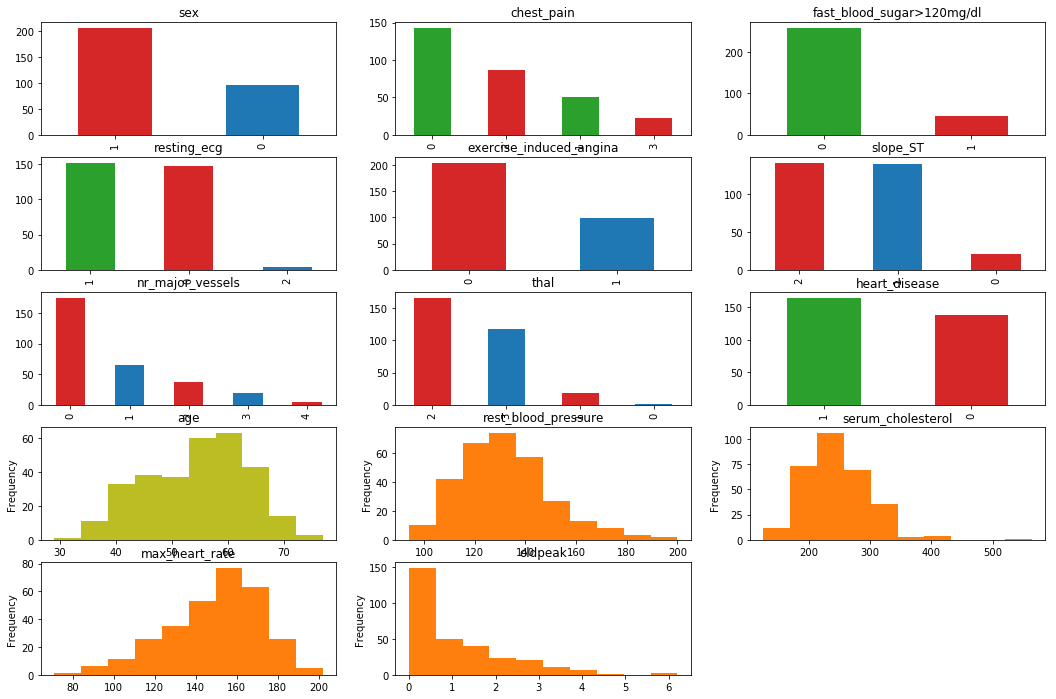

In [51]:
#rename columns
rename_col = {'cp':'chest_pain',
              'trestbps':'rest_blood_pressure',
              'chol':'serum_cholesterol',
              'fbs':'fast_blood_sugar>120mg/dl',
              'restecg':'resting_ecg',
              'thalach':'max_heart_rate',
            'exang':'exercise_induced_angina',
             'slope':'slope_ST',
              'ca':'nr_major_vessels',
              'target':'heart_disease'}

df_data_raw.rename(rename_col,axis='columns', inplace=True)
df_data = df_data_raw


fig, axes = plt.subplots(nrows=5,ncols=3,figsize=(18,12))

df_data['sex'].value_counts().plot(kind='bar', color=['tab:red', 'tab:blue'],ax=axes[0,0], title='sex')
df_data['chest_pain'].value_counts().plot(kind='bar', color=['tab:green', 'tab:red'], ax=axes[0,1], title='chest_pain')
df_data['fast_blood_sugar>120mg/dl'].value_counts().plot(kind='bar', color=['tab:green', 'tab:red'],ax=axes[0,2], title='fast_blood_sugar>120mg/dl')
df_data['resting_ecg'].value_counts().plot(kind='bar', color=['tab:green', 'tab:red', 'tab:blue', 'tab:purple', 'tab:cyan'],ax=axes[1,0], title='resting_ecg')
df_data['exercise_induced_angina'].value_counts().plot(kind='bar', color=['tab:red', 'tab:blue'],ax=axes[1,1], title='exercise_induced_angina')
df_data['slope_ST'].value_counts().plot(kind='bar', color=['tab:red', 'tab:blue'],ax=axes[1,2], title='slope_ST')
df_data['nr_major_vessels'].value_counts().plot(kind='bar', color=['tab:red', 'tab:blue'],ax=axes[2,0], title='nr_major_vessels')
df_data['thal'].value_counts().plot(kind='bar', color=['tab:red', 'tab:blue'],ax=axes[2,1], title='thal')
df_data['heart_disease'].value_counts().plot(kind='bar', color=['tab:green', 'tab:red'],ax=axes[2,2], title='heart_disease')


df_data['age'].plot(kind='hist',title='age', color='tab:olive',ax=axes[3,0])
df_data['rest_blood_pressure'].plot(kind='hist',title='rest_blood_pressure', color='tab:orange', ax=axes[3,1])
df_data['serum_cholesterol'].plot(kind='hist',title='serum_cholesterol', color='tab:orange', ax=axes[3,2])
df_data['max_heart_rate'].plot(kind='hist',title='max_heart_rate', color='tab:orange', ax=axes[4,0])
df_data['oldpeak'].plot(kind='hist',title='oldpeak', color='tab:orange', ax=axes[4,1])



fig.delaxes(axes[4][2])


## Data Wrangling

In [52]:
#rearrange df
df_data = df_data[['sex','age','chest_pain','rest_blood_pressure','serum_cholesterol',
                   'fast_blood_sugar>120mg/dl','resting_ecg', 'max_heart_rate', 'exercise_induced_angina',
                  'oldpeak', 'slope_ST', 'nr_major_vessels', 'thal', 'heart_disease'  ]]
#input variables X
X = df_data[['sex','age','chest_pain','rest_blood_pressure','serum_cholesterol',
                   'fast_blood_sugar>120mg/dl','resting_ecg', 'max_heart_rate', 'exercise_induced_angina',
                  'oldpeak', 'slope_ST', 'nr_major_vessels', 'thal']]
#output variable y
y = df_data['heart_disease']

## Data Preparation

In [53]:
categorial = df_data[['sex','chest_pain',
                   'fast_blood_sugar>120mg/dl','resting_ecg', 'exercise_induced_angina',
                   'slope_ST', 'nr_major_vessels', 'thal']].values

#onehotencode categorical data
def onehotencode(categorial_data):
    encoded_X = None
    for i in range(0, categorial_data.shape[1]):
        label_encoder = LabelEncoder()
        feature = label_encoder.fit_transform(categorial_data[:,i])
        feature = feature.reshape(categorial_data.shape[0], 1)
        onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
        feature = onehot_encoder.fit_transform(feature)
        #add feature to encoded_X
        if encoded_X is None:
            encoded_X = feature
        else:
            encoded_X = np.concatenate((encoded_X, feature), axis=1)
    return encoded_X

encoded_X = onehotencode(categorial)


#add int and float data
numeric_cols = ['age', 'rest_blood_pressure', 'serum_cholesterol', 'max_heart_rate', 'oldpeak' ]
for col in numeric_cols:
    values = X[col].values
    values = values.reshape(values.shape[0],1)
    encoded_X = np.concatenate((encoded_X, values), axis=1)
    
#reshape output variables
reshaped_y = y.values
reshaped_y = reshaped_y.reshape(y.shape[0],) 
     
#split train and test data
X_train, X_test, y_train, y_test = train_test_split(encoded_X, reshaped_y, test_size = 0.25)

## Model

In [54]:
eval_set =[(X_train, y_train), (X_test, y_test)]

#fit model
model = XGBClassifier()
model.fit(X_train, y_train,early_stopping_rounds=10, eval_metric=['error', 'logloss'], eval_set=eval_set, verbose=False) 
print(model)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)
Accuracy: 88.16%


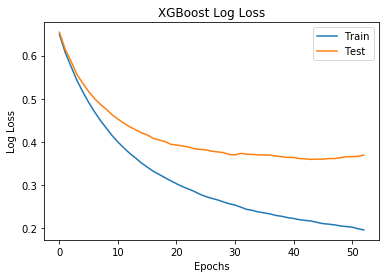

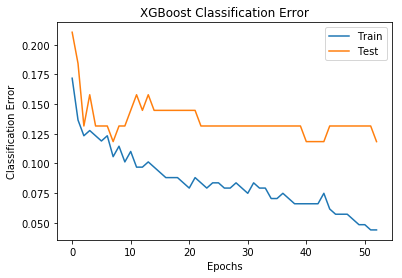

In [55]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.xlabel('Epochs')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.xlabel('Epochs')
plt.show()

## Feature Importance

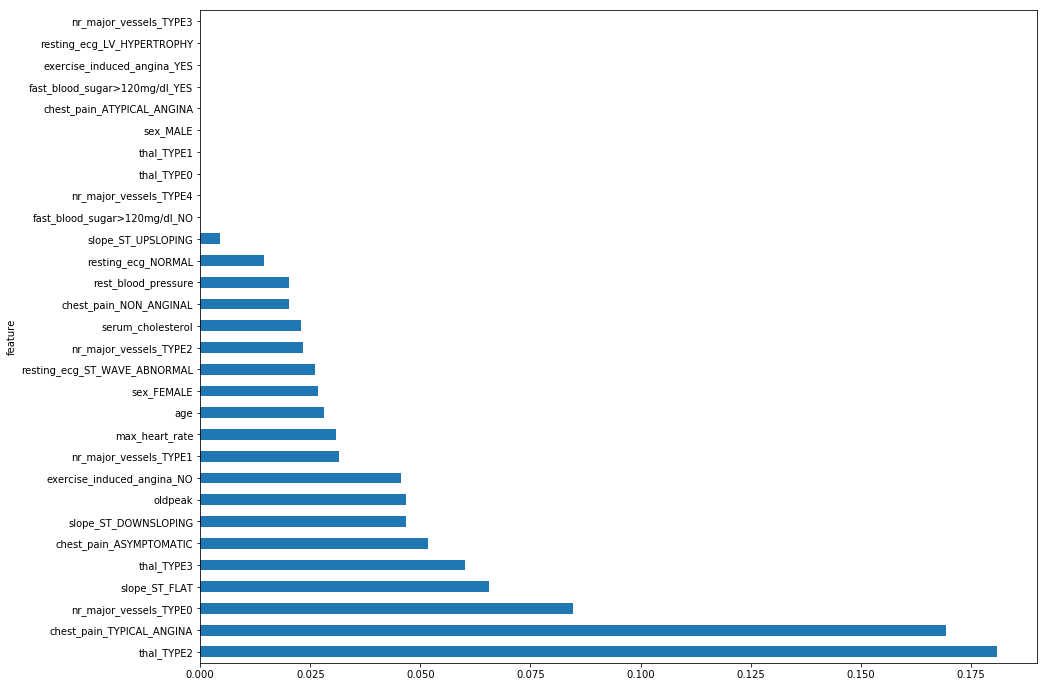

In [78]:
#encoded_X col labels:  
labels = ['sex_FEMALE', 'sex_MALE', 'chest_pain_TYPICAL_ANGINA','chest_pain_ATYPICAL_ANGINA','chest_pain_NON_ANGINAL','chest_pain_ASYMPTOMATIC',
         'fast_blood_sugar>120mg/dl_NO', 'fast_blood_sugar>120mg/dl_YES', 'resting_ecg_NORMAL','resting_ecg_ST_WAVE_ABNORMAL','resting_ecg_LV_HYPERTROPHY',
         'exercise_induced_angina_NO', 'exercise_induced_angina_YES','slope_ST_UPSLOPING', 'slope_ST_FLAT', 'slope_ST_DOWNSLOPING',
         'nr_major_vessels_TYPE0','nr_major_vessels_TYPE1', 'nr_major_vessels_TYPE2','nr_major_vessels_TYPE3', 'nr_major_vessels_TYPE4',
          'thal_TYPE0', 'thal_TYPE1', 'thal_TYPE2', 'thal_TYPE3',
         'age', 'rest_blood_pressure', 'serum_cholesterol', 'max_heart_rate', 'oldpeak' ]  

df_enc = pd.DataFrame(encoded_X)
df_enc.columns = labels

def feature_imp(df,model):
    fi = pd.DataFrame()
    fi["feature"] = df.columns
    fi["importance"] = model.feature_importances_
    return fi.sort_values(by="importance", ascending=False)

feature_imp(df_enc ,model).plot('feature', 'importance', kind='barh', figsize=(15,12), legend=False)

## Receiver Operator Characteristic (ROC)

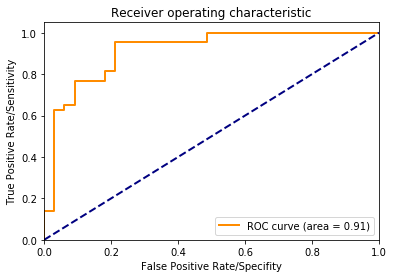

In [89]:
#calc false positve rate and true positive rate
y_predi = model.fit(X_train, y_train).predict_proba(X_test)[:,1] 
fpr, tpr, _ = roc_curve(y_test, y_predi)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate/Specifity')
plt.ylabel('True Positive Rate/Sensitivity')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Predict whether or not you suffer from heart disease

In [14]:
# TODO: adapt to UCI-dataset
gender_female = 1 
gender_male = 0
gender_diverse = 0
diabetes_0 = 1  
diabetes_1 = 0
hypertension_0 = 0
hypertension_1 = 1
stroke_0 = 0
stroke_1 = 1
smoking_history_current = 0
smoking_history_ever = 1
smoking_history_former = 0
smoking_history_never = 0
smoking_history_not_current = 0


'''
gender = 'Female' #'Male', 'Female'
diabetes = 0      #O- no; 1- yes
hypertension = 0 #O- no; 1- yes
stroke = 0        #O- no; 1- yes
smoking_history = 'never' #'current', 'ever', 'former', 'never', 'not current'
'''

age = 70.0        #O- no; 1- yes
BMI =  70/1.65**2 # mass/height², Units: mass-->[kg], height--> [m]



predict = np.array([[gender_female, gender_male, gender_diverse,
                 diabetes_0, diabetes_1, 
                 hypertension_0, hypertension_1, 
                 stroke_0, stroke_1, 
                 smoking_history_current, smoking_history_ever, smoking_history_former, smoking_history_never, smoking_history_not_current,
                 age,
                 BMI]])

print(model.predict(predict)[0])


1
